# Demonstration of PyCIRAS

## Usage

The user needs to import the setup script to build the environment

In [1]:
import setup_notebook_environment

After this - the user can access the functionality through a variety of entry points on the form **pyciras.run_**

In [2]:
import pyciras

### Full Analysis - Code Quality, Git metrics, Unit-Testing, Stargazers data

The user can specify a list of git repos they want to analyze directly in the notebook, or in the default **/repos.txt** file.

In [3]:
repos = ['https://github.com/SamuelThand/TDD-Hangman',
         'https://github.com/coinse/sadl',
         'https://github.com/zhangj111/astnn']

There are some options for the analysis:

- Repo URLs
- Chunk Size - How many repos the program should analyze before writing results to disk
- Paralellism - If the program should use subprocesses equal to the chunk size, to speed up computation
- Remove Repos - The program can remove the downloaded repositories after the analysis, to save storage space

For long-running analysis, we support **ntfy** push notifications, so you can leave it running and get notified when completed.

In [5]:
pyciras.run_full_analysis(repo_urls=repos, chunk_size = 2, parallelism = False, remove_repos_after_completion=False)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

### Single Analysis - More targeted and efficient mining for specific data

In [ ]:
pyciras.run_repo_cloner()

In [ ]:
pyciras.run_pydriller_analysis()

In [ ]:
pyciras.run_code_quality_analysis()

In [ ]:
pyciras.run_unit_testing_analysis()

In [ ]:
pyciras.run_stargazers_analysis()

### Gaining insights from the data

We have included tools for data analysis and visualisation, that can be used to examine the data aquired through our tool.

The data produced during the experiment can always be found in the **pyciras.data_directory**, which is the timestamped data directory for the analysis


#### Plotting

In [21]:
from utility import config
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
df = pd.read_csv(
    config.DATA_FOLDER / pyciras.data_directory / "stargazers-over-time.csv")

/tmp/ipykernel_104872/3516955227.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').last()


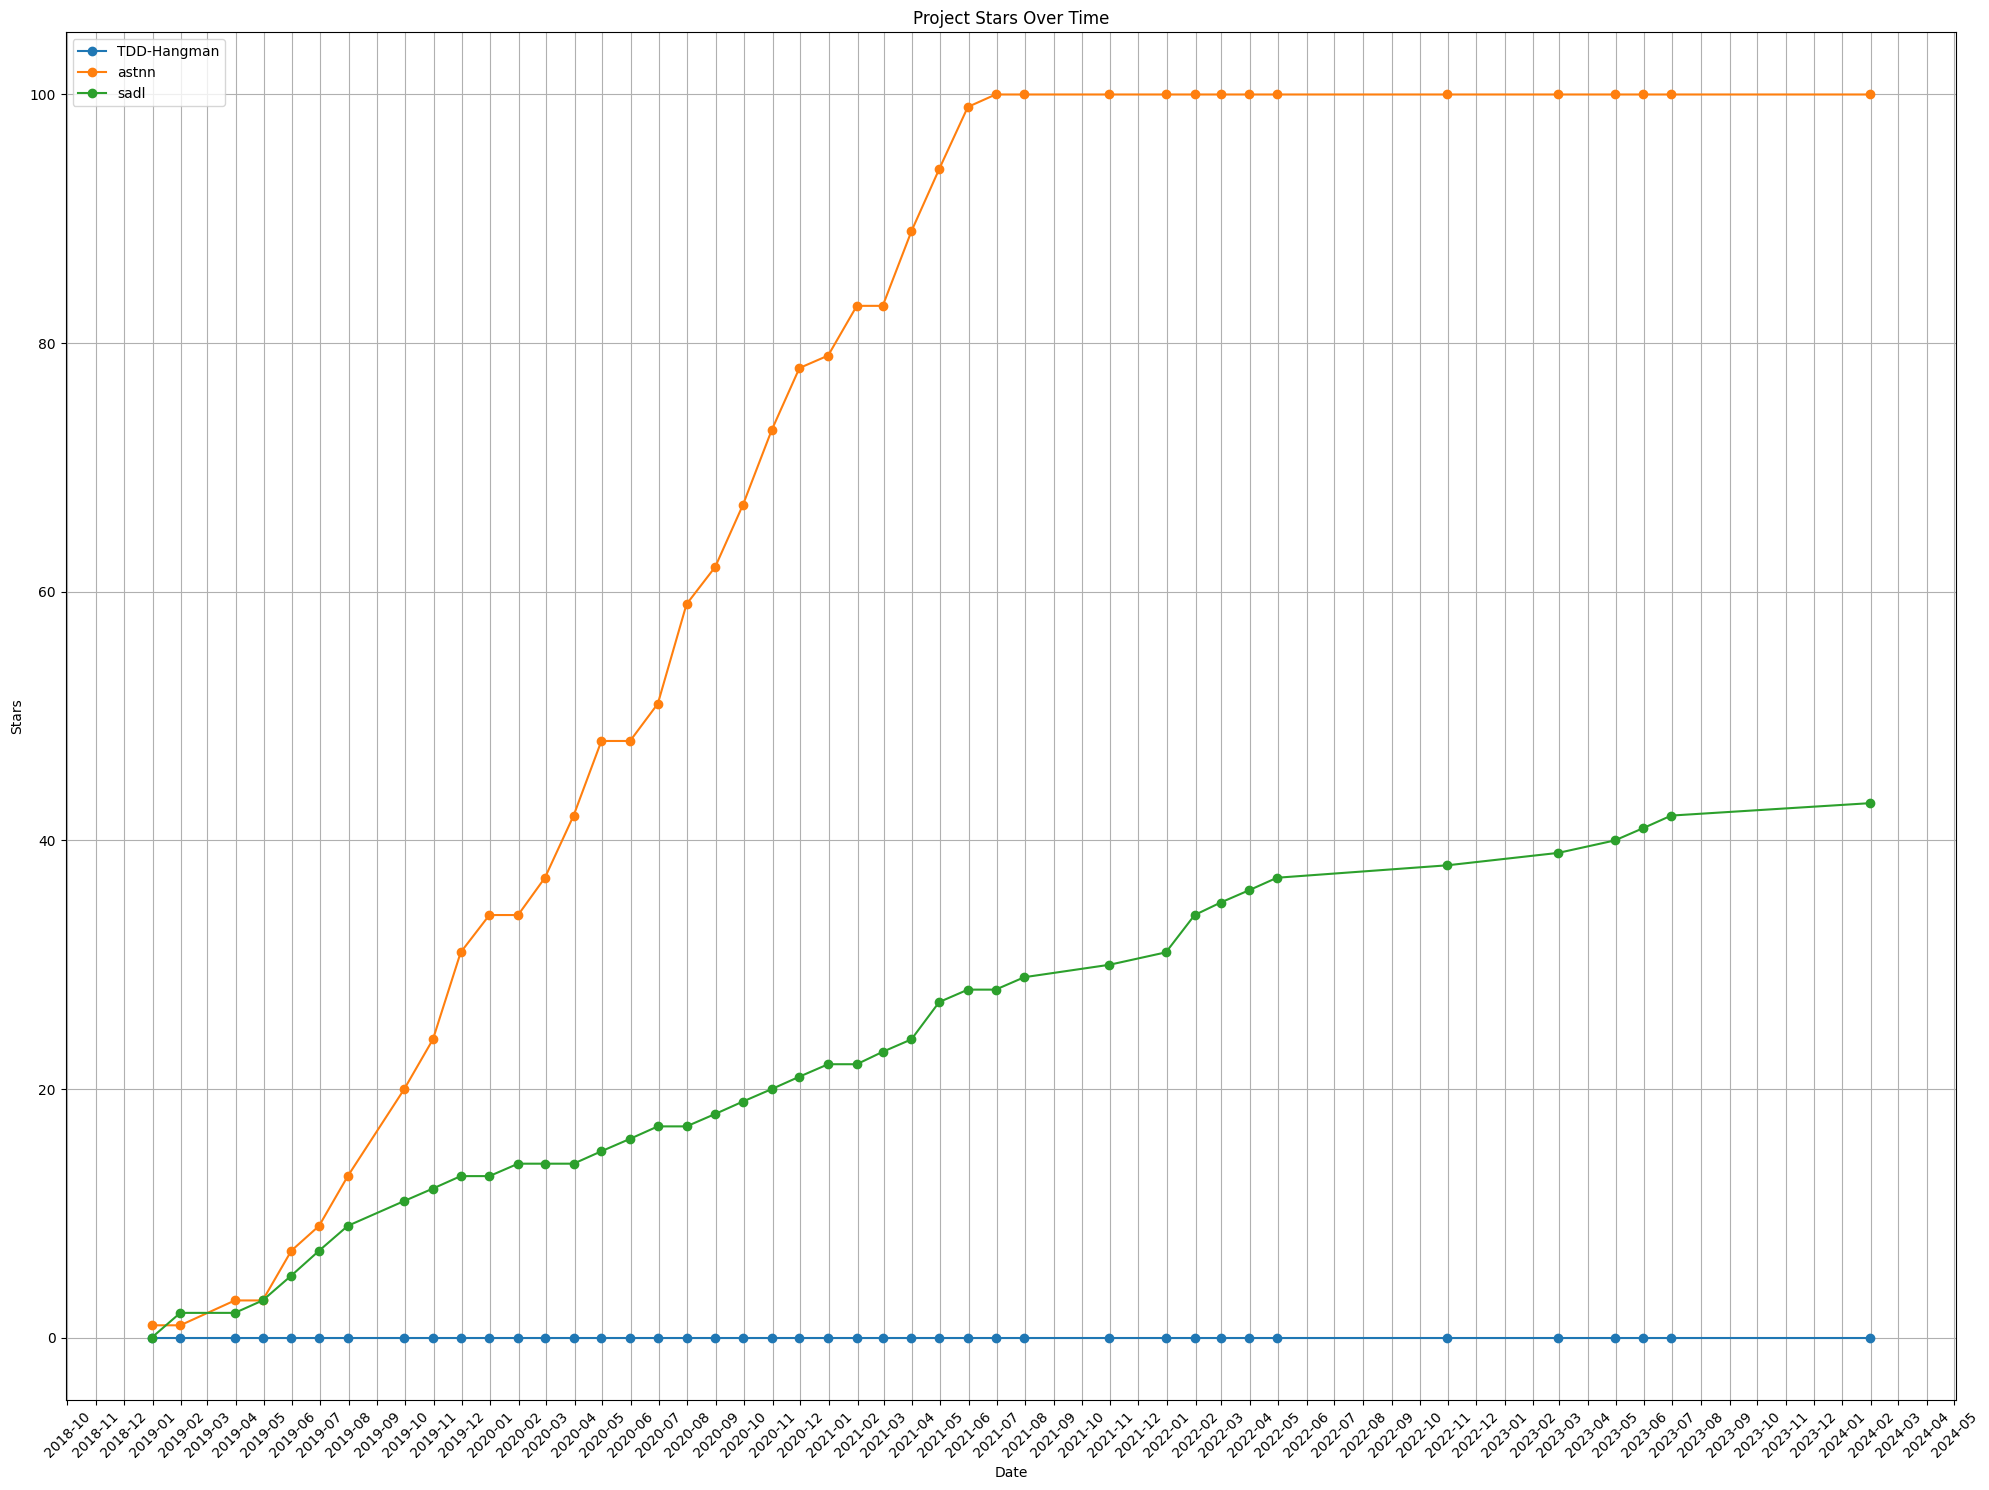

In [23]:
# Assuming df is already loaded and 'DATE' has been set as datetime and index
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

# Resample to get the last entry of each month
df_monthly = df.resample('M').last()

# Drop rows where all values except 'DATE' are NaN
df_monthly.dropna(how='all', inplace=True)

# Reset index to get 'DATE' back as a column for plotting
df_line = df_monthly.reset_index()

# plotting
plt.figure(figsize=(20, 15))
for column in df_line.columns[1:]:  # Adjust column indexing if necessary
    plt.plot(df_line['DATE'], df_line[column], marker='o', label=column)

plt.title('Project Stars Over Time')
plt.xlabel('Date')
plt.ylabel('Stars')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Improve the date format on the X-axis
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())

plt.tight_layout()
plt.show()

## Statistical Analysis

Lets say we are interested in doing a correlation analysis between the Pylint score of a project, and the amount of stars it has.

### Extracting the relevant data

In [34]:
astnn_pylint = pd.read_csv(config.DATA_FOLDER / pyciras.data_directory / "pylint-astnn.csv")
stargazers_over_time = pd.read_csv(config.DATA_FOLDER / pyciras.data_directory / "stargazers-over-time.csv")

In [35]:
astnn_pylint

,stats.by_msg.super-init-not-called,stats.bad_names.function,stats.bad_names.inlinevar,stats.by_module.astnn.clone.utils.refactor,stats.by_module.astnn.tree.refactor,stats.by_module.astnn.config.fatal,stats.by_msg.too-many-branches,stats.undocumented.method,stats.by_module.astnn.clone.__init__.refactor,stats.by_msg.consider-using-f-string,...,stats.dependencies.pycparser.c_parser,stats.by_module.astnn.clone.utils.warning,stats.by_module.astnn.clone.tree.convention,stats.by_module.astnn.clone.tree.warning,stats.percent_duplicated_lines,stats.code_type_count.empty,stats.by_module.astnn.__init__.refactor,stats.node_count.function,stats.bad_names.variable,stats.global_note
0,2,0,0,2,4,NaN,5,36,19,3,...,"{'astnn.pipeline', 'astnn.prepare_data', 'astn...",3,11,1,20.928519,0,0,19,0,5.748560
1,2,0,0,2,4,NaN,5,36,19,3,...,"{'astnn.pipeline', 'astnn.prepare_data', 'astn...",3,11,1,20.928519,0,0,19,0,5.748560
2,2,0,0,2,4,NaN,5,36,19,3,...,"{'astnn.pipeline', 'astnn.prepare_data', 'astn...",3,11,1,20.928519,0,0,19,0,5.748560
3,2,0,0,2,4,NaN,5,36,19,3,...,"{'astnn.pipeline', 'astnn.prepare_data', 'astn...",3,11,1,20.928519,0,0,19,0,5.748560
4,2,0,0,2,4,NaN,5,36,19,3,...,"{'astnn.pipeline', 'astnn.prepare_data', 'astn...",3,11,1,20.928519,0,0,19,0,5.748560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,2,0,0,2,4,0.0,5,36,0,3,...,"{'astnn.pipeline', 'astnn.prepare_data', 'astn...",3,11,1,19.656357,0,0,19,0,5.809793
84,2,0,0,2,4,0.0,5,36,0,3,...,"{'astnn.pipeline', 'astnn.prepare_data', 'astn...",3,11,1,20.000000,0,0,19,0,5.790960
85,2,0,0,2,4,0.0,5,36,0,3,...,"{'astnn.pipeline', 'astnn.prepare_data', 'astn...",3,11,1,19.668737,0,0,19,0,5.800377
86,2,0,0,2,4,0.0,5,36,0,3,...,"{'astnn.pipeline', 'astnn.prepare_data', 'astn...",3,11,1,19.668737,0,0,19,0,5.800377


In [33]:
stargazers_over_time

,DATE,TDD-Hangman,astnn,sadl
0,2019-01-03,0,1,1
1,2019-01-16,0,1,2
2,2019-04-12,0,3,3
3,2019-05-07,0,3,4
4,2019-05-31,0,7,5
...,...,...,...,...
128,2021-05-07,0,95,27
129,2021-05-14,0,96,27
130,2021-05-16,0,97,27
131,2021-05-25,0,99,28


In [43]:
astnn_global_note_over_time = astnn_pylint[['date', 'stats.global_note']]
astnn_stargazers_over_time = stargazers_over_time[['DATE', 'astnn']]

In [45]:
astnn_global_note_over_time

,date,stats.global_note
0,2018-08-23 18:45:14+08:00,5.748560
1,2018-08-23 19:42:01+08:00,5.748560
2,2018-08-23 19:43:25+08:00,5.748560
3,2018-08-23 19:54:30+08:00,5.748560
4,2018-08-23 20:04:16+08:00,5.748560
...,...,...
83,2024-02-13 15:51:13+08:00,5.809793
84,2024-02-13 15:54:55+08:00,5.790960
85,2024-02-13 15:55:37+08:00,5.800377
86,2024-02-13 16:23:58+08:00,5.800377


In [46]:
astnn_stargazers_over_time

,DATE,astnn
0,2019-01-03,1
1,2019-01-16,1
2,2019-04-12,3
3,2019-05-07,3
4,2019-05-31,7
...,...,...
128,2021-05-07,95
129,2021-05-14,96
130,2021-05-16,97
131,2021-05-25,99


### Joining the dataframes on DATE using an As Of Join

This type of join is useful when you want to merge observations as of certain times without having exact matches in time. For instance, if you have a value on 2024-02-13 in one set and the closest date in the other set is 2024-02-12, it will merge these two records.

In [54]:
# Convert 'date' columns to datetime format
astnn_global_note_over_time['date'] = pd.to_datetime(astnn_pylint['date'], utc=True).dt.date

# For 'DATE' column in 'stargazers_over_time', first ensure it's a datetime with the correct timezone,
# then convert to a naive datetime by removing the timezone
astnn_stargazers_over_time['DATE'] = pd.to_datetime(stargazers_over_time['DATE'], utc=True).dt.tz_localize(None).dt.date

/tmp/ipykernel_104872/2310026396.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  astnn_global_note_over_time['date'] = pd.to_datetime(astnn_pylint['date'], utc=True).dt.date
/tmp/ipykernel_104872/2310026396.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  astnn_stargazers_over_time['DATE'] = pd.to_datetime(stargazers_over_time['DATE'], utc=True).dt.tz_localize(None).dt.date


In [55]:
astnn_global_note_over_time

,date,stats.global_note
0,2018-08-23,5.748560
1,2018-08-23,5.748560
2,2018-08-23,5.748560
3,2018-08-23,5.748560
4,2018-08-23,5.748560
...,...,...
83,2024-02-13,5.809793
84,2024-02-13,5.790960
85,2024-02-13,5.800377
86,2024-02-13,5.800377


In [56]:
astnn_stargazers_over_time

,DATE,astnn
0,2019-01-03,1
1,2019-01-16,1
2,2019-04-12,3
3,2019-05-07,3
4,2019-05-31,7
...,...,...
128,2021-05-07,95
129,2021-05-14,96
130,2021-05-16,97
131,2021-05-25,99


#### As Of Join

In [75]:
astnn_global_note_over_time_sorted = astnn_global_note_over_time.sort_values('date', ascending=True)
astnn_stargazers_over_time_sorted = astnn_stargazers_over_time.sort_values('DATE', ascending=True)

# Sort the DataFrames by 'date' column
astnn_global_note_over_time_sorted = astnn_global_note_over_time.sort_values('date')
astnn_stargazers_over_time_sorted = astnn_stargazers_over_time.sort_values('DATE')

# Perform the 'as of' merge
global_note_stargazers_asof = pd.merge_asof(
    left=astnn_global_note_over_time_sorted,
    right=astnn_stargazers_over_time_sorted,
    left_on='date',
    right_on='DATE',
    direction='nearest',
    tolerance=pd.Timedelta('1000 days')  # TODO Adjust the tolerance as per your data's requirements, will not match correctly if too far between
)

# Now global_note_stargazers_asof will contain the merged data


In [80]:
# Set the display option to show all rows
pd.set_option('display.max_rows', None)

global_note_stargazers_asof

,date,stats.global_note,DATE,astnn
0,2018-08-23,5.748560,2018-12-26,1
1,2018-08-23,5.748560,2018-12-26,1
2,2018-08-23,5.748560,2018-12-26,1
3,2018-08-23,5.748560,2018-12-26,1
4,2018-08-23,5.748560,2018-12-26,1
5,2018-08-23,5.748560,2018-12-26,1
6,2018-08-23,5.748560,2018-12-26,1
7,2018-08-23,5.748560,2018-12-26,1
8,2018-08-23,5.748560,2018-12-26,1
9,2018-08-23,5.748560,2018-12-26,1


# Conclusion of demo experiment

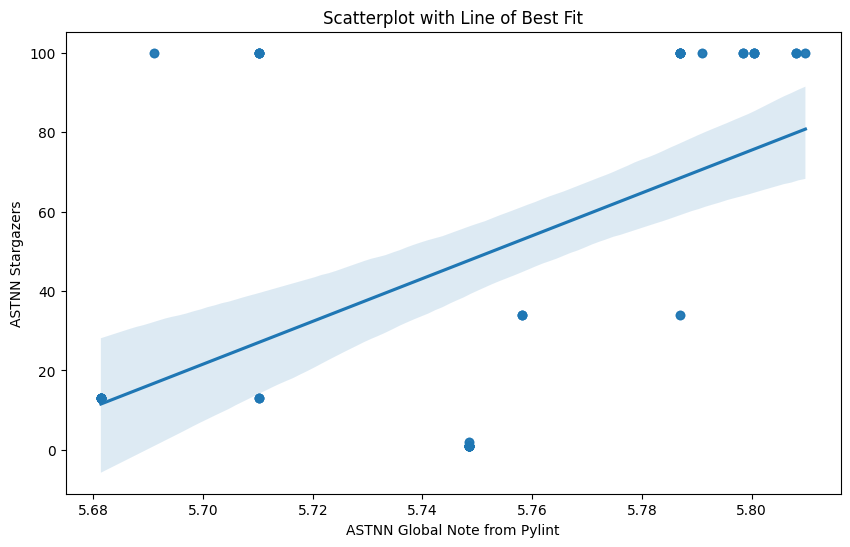

Correlation: 0.48152730584767517

Descriptive statistics for astnn global note:
count    88.000000
mean      5.749386
std       0.041211
min       5.681382
25%       5.710173
50%       5.748560
75%       5.786948
max       5.809793
Name: stats.global_note, dtype: float64

Descriptive statistics for astnn stargazers over time:
count     88.000000
mean      48.204545
std       46.137017
min        1.000000
25%        1.000000
50%       23.500000
75%      100.000000
max      100.000000
Name: astnn, dtype: float64


In [91]:
# Now you can perform correlation analysis and descriptive statistics on 'stats.global_note' and 'astnn' in the merged_data dataframe

import seaborn as sns

# Create a scatterplot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='stats.global_note', y='astnn', data=global_note_stargazers_asof, fit_reg=True)

plt.title('Scatterplot with Line of Best Fit')
plt.xlabel('ASTNN Global Note from Pylint')
plt.ylabel('ASTNN Stargazers')
plt.show()

correlation = global_note_stargazers_asof['stats.global_note'].corr(global_note_stargazers_asof['astnn'])

astnn_global_note_over_time
astnn_stargazers_over_time

# Print the correlation
print('Correlation:', correlation)
print()

# Descriptive statistics
print('Descriptive statistics for astnn global note:')
print(global_note_stargazers_asof['stats.global_note'].describe())

print('\nDescriptive statistics for astnn stargazers over time:')
print(global_note_stargazers_asof['astnn'].describe())